# Mixture averaging and coincidence probabilities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyrepseq as prs

from lib import *

plt.style.use('tcrspace.mplstyle')

pcDelta_kwargs = dict(pseudocount=0.0, normalize=True)

## Load Multimer data

In [2]:
dash = pd.read_csv(f'{data_directory}/dash_human.csv')
dash_pcDeltas = prs.pcDelta_grouped(dash, 'epitope',
                                    ['cdr3_a_aa', 'cdr3_b_aa'],
                                    **pcDelta_kwargs)

In [3]:
minervina = pd.read_csv(f'{data_directory}/minervina2022.csv')
minervina = minervina.groupby('epitope').filter(lambda x: len(x) > 150)
minervina_pcDeltas = prs.pcDelta_grouped(minervina, 'epitope',
                                           ['cdr3a', 'cdr3b'],
                                           **pcDelta_kwargs)

In [4]:
multimer_pcDeltas = pd.concat([dash_pcDeltas, minervina_pcDeltas])

## Load Tanno et al. data

In [5]:
data_dir = 'data/tanno/pruned'
dfs = {f : pd.read_csv(f'{data_dir}/pdist_{f}.csv') for f in tannofiles}

In [6]:
fabs_dict = {}
fab_inds_dict = {}
for which_one in ['PBMC', 'memory','naive']:
    fabs = []
    fab_inds = []
    for filename, df in dfs.items():
        if which_one not in filename and which_one != 'PBMC':
            continue
        if which_one == 'PBMC' and ('memory' in filename or 'naive' in filename):
            continue
        bins = df['bins']
        fab = df['freq_pair']
        fabs.append(fab)
        fa = df['freq_alpha']
        fb = df['freq_beta']
        fab_ind = np.convolve(fa, fb, mode='full')[:fab.shape[0]]
        fab_inds.append(fab_ind)
    fabs = np.array(fabs)
    fab_inds = np.array(fab_inds)
    fabs_dict[which_one] = fabs
    fab_inds_dict[which_one] = fab_inds

## Visualize

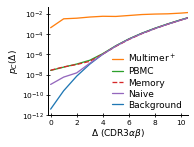

In [7]:
fig, ax = plt.subplots(figsize=(2.5, 2.0))

hist_norm = np.mean(multimer_pcDeltas, axis=0)
ax.plot(np.arange(len(hist_norm)), hist_norm, '-', label='Multimer$^+$', color='C1')

for i, which_one in enumerate(['PBMC', 'memory', 'naive']):
    fab = fabs_dict[which_one].mean(axis=0)
    fab_std = fabs_dict[which_one].std(axis=0)
    ax.plot(bins, fab, '--' if which_one =='memory' else '-', color=f'C{i+2}',
            label=which_one if which_one =='PBMC' else which_one.capitalize())
    
fab_ind = fab_inds_dict['PBMC'].mean(axis=0)
ax.plot(bins, fab_ind, '-', label='Background', color='C0', zorder=-5)
    
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.0))

ax.set_xlim(-0.2, 10.5)
ax.set_ylim(1e-12, 5e-2)

ax.set_yscale('log')
ax.set_xlabel(r'$\Delta$ (CDR3$\alpha\beta$)')
ax.set_ylabel('$p_C(\Delta)$')

fig.savefig('figures/figure6.svg')

In [8]:
'%e'%fab_ind[0], '%e'%fabs_dict['PBMC'].mean(axis=0)[0], '%e'%np.mean(multimer_pcDeltas, axis=0)[0]

('4.027384e-12', '2.603449e-08', '4.158932e-04')